In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [ ]:
benign_train = np.array(Dataset_loader('/content/drive/MyDrive/code ddsm 2(new)/benign_train',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/code ddsm 2(new)/malignant_train',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/code ddsm 2(new)/benign_test',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/code ddsm 2(new)/malignant_test',224))
benign_validation = np.array(Dataset_loader('/content/drive/MyDrive/code ddsm 2(new)/benign_validation',224))
malign_validation = np.array(Dataset_loader('/content/drive/MyDrive/code ddsm 2(new)/malignant_validation',224))

100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print('Resized Dimensions : ',benign_train.shape)
print('Resized Dimensions : ',benign_test.shape)
print('Resized Dimensions : ',malign_train.shape)
print('Resized Dimensions : ',malign_test.shape)
print('Resized Dimensions : ',malign_validation.shape)
print('Resized Dimensions : ',malign_validation.shape)

Resized Dimensions :  (300, 224, 224, 3)
Resized Dimensions :  (100, 224, 224, 3)
Resized Dimensions :  (300, 224, 224, 3)
Resized Dimensions :  (100, 224, 224, 3)
Resized Dimensions :  (100, 224, 224, 3)
Resized Dimensions :  (100, 224, 224, 3)


In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
benign_validation_label = np.zeros(len(benign_validation))
malign_validation_label = np.ones(len(malign_validation))

In [ ]:
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)
X_val = np.concatenate((benign_validation, malign_validation),axis=0)
Y_val = np.concatenate((benign_validation_label, malign_validation_label),axis=0)

In [ ]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [ ]:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
s = np.arange(X_val.shape[0])
np.random.shuffle(s)
X_val = X_val[s]
Y_val = Y_val[s]

In [ ]:
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
Y_val = to_categorical(Y_val, num_classes= 2)

In [ ]:
acc_per_fold = []
loss_per_fold = []
sens_per_fold = [] 
spec_per_fold = []
prec_per_fold = []

In [ ]:
inputs = np.concatenate((X_train, X_val), axis=0)
targets = np.concatenate((Y_train, Y_val), axis=0)

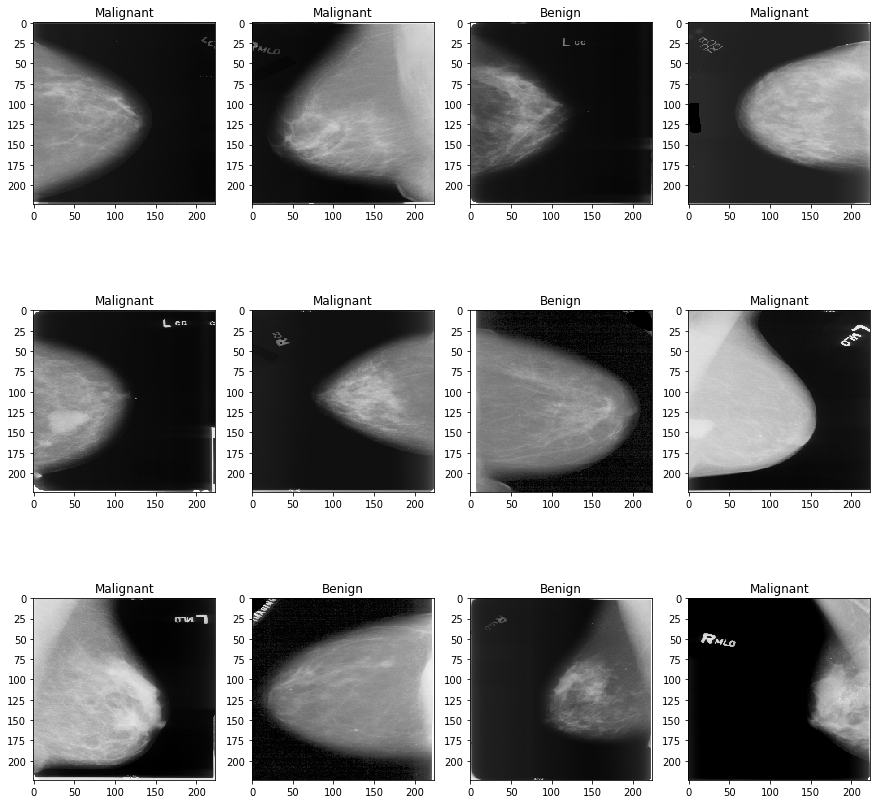

In [ ]:
# # Display first 15 images , and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(targets[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(inputs[i], interpolation='nearest')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19



In [ ]:
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation

fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    
    def build_model(backbone, learning_rate=1e-5):
        
        model = Sequential()
        model.add(backbone)
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dropout(0.5))
        model.add(layers.BatchNormalization())
        model.add(Dense(512, activation='relu'))
        model.add(layers.Dense(2, activation='softmax'))
        
    
    
        model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])
    
        return model


    vgg = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3))


 
    model = build_model(vgg ,learning_rate = 1e-5)
    
   # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.fit(
    inputs[train], targets[train],
    epochs=25,
    batch_size=32,
    validation_data=(inputs[test],targets[test]),
    shuffle=True
    )
    
    predictions = model.predict(X_test)
    true_classes = Y_test
    # evaluate validation performance
    print("**Performance on Validation data**")    
    cm = confusion_matrix(np.argmax(true_classes, axis=1), np.argmax(predictions, axis=1))
    print(cm)
    print(classification_report( np.argmax(true_classes, axis=1), np.argmax(predictions, axis=1)))

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negative
    FN = cm[1,0] # false negative
    FP = cm[0,1] # false positive
    print(f"  {TP}\n  {TN}\n {FP}\n  {FN}\n ")
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)



    print(f"Trial Metrics:")
    print(f"Sensitivity: {TPR}\nSpecifity: {TNR}\nPrecision: {PPV} ")
    

    scores = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%' )
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    sens_per_fold.append(TPR) 
    spec_per_fold.append(TNR)  
    prec_per_fold.append(PPV) 
   
    

    fold_no = fold_no + 1


# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)} (+- {np.std(loss_per_fold)})')
print(f'> Sensitivity: {np.mean(sens_per_fold)} (+- {np.std(sens_per_fold)})')
print(f'> Specifity: {np.mean(spec_per_fold)} (+- {np.std(spec_per_fold)})')
print(f'> Precision: {np.mean(prec_per_fold)} (+- {np.std(prec_per_fold)})')
print('------------------------------------------------------------------------')

80150528/80134624 [==============================] - 2s 0us/step
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
20/20 [==============================] - 41s 1s/step - loss: 0.7222 - accuracy: 0.6141 - val_loss: 0.5972 - val_accuracy: 0.7000
Epoch 2/25
20/20 [==============================] - 23s 1s/step - loss: 0.6017 - accuracy: 0.7172 - val_loss: 0.5286 - val_accuracy: 0.7375
Epoch 3/25
20/20 [==============================] - 22s 1s/step - loss: 0.5202 - accuracy: 0.7719 - val_loss: 0.5085 - val_accuracy: 0.7312
Epoch 4/25
20/20 [==============================] - 22s 1s/step - loss: 0.4815 - accuracy: 0.7750 - val_loss: 0.4788 - val_accuracy: 0.7688
Epoch 5/25
20/20 [==============================] - 23s 1s/step - loss: 0.4342 - accuracy: 0.8016 - val_loss: 0.4588 - val_accuracy: 0.8125
Epoch 6/25
20/20 [==============================] - 22s 1s/step - loss: 0.3805 - accuracy: 0.8391 - val_loss: 0.4347 - val_accuracy: 0.825